In [3]:
import autogluon.shift as sft

In [5]:
%run ../tests/unittests/models/test_classifier2ST.py
from sklearn import metrics, model_selection
from autogluon.tabular import TabularPredictor
import plotnine as p9
import bisect

## Importing data

We will import the adult dataset.  In the following analysis we will construct a dataset with covariate shift.  This means that we will need to identify a feature that can be used to bias the training sample, in order to make it not representative of the test population.  As we can see the marital status has a good mix of married and never-married, making it a potential candidate 

In [11]:
data_dir = '../tests/data'

train, test = load_adult_data()

train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,178478,Bachelors,13,Never-married,Tech-support,Own-child,White,Female,0,0,40,United-States,<=50K
1,23,State-gov,61743,5th-6th,3,Never-married,Transport-moving,Not-in-family,White,Male,0,0,35,United-States,<=50K
2,46,Private,376789,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,15,United-States,<=50K
3,55,?,200235,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,50,United-States,>50K
4,36,Private,224541,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,El-Salvador,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,54,Private,83103,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,67,United-States,<=50K
39069,23,Private,172232,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,53,United-States,<=50K
39070,37,Local-gov,165883,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
39071,26,Self-emp-not-inc,67240,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,35,United-States,<=50K


In [9]:
train[['marital-status']].value_counts(normalize=True)

marital-status        
 Married-civ-spouse       0.458705
 Never-married            0.330586
 Divorced                 0.134338
 Separated                0.031787
 Widowed                  0.031377
 Married-spouse-absent    0.012592
 Married-AF-spouse        0.000614
dtype: float64

## Detecting XShift

First we will apply the XShift detector to the original adults dataset.  We see that our test does not detect a substantial difference between the training and test X distributions.  This was determined by calculating the balanced accuracy (50.02%) for a classifier, which predicts if a sample is in the test or training set.  This is so close to 50% (random guessing) that we suspect that the adults training/test sets are a random sample split.

In [14]:
xsd = sft.XShiftDetector(TabularPredictor, label='class')

No path specified. Models will be saved in: "AutogluonModels/ag-20220802_200342/"


In [15]:
xsd.fit(train, test)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220802_200342/"
AutoGluon Version:  0.4.3b20220616
Python Version:     3.8.0
Operating System:   Linux
Train Data Rows:    24421
Train Data Columns: 14
Label Column: xshift_label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14802.25 MB
	Train Data (Original)  Memory Usage: 14.32 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually sp

In [16]:
sumry = xsd.summary()

In [18]:
sumry

'# Detecting distribution shiftWe did not detect a substantial difference between the training and test X distributions.'

In [21]:
xsd.C2ST.test_stat

0.5001811040326062

## Simulating covariate shift

In this section, we will simulate covariate shift for the adults dataset.  We do this by finding a variable that has both high enough entropy to be useful to bias the training data, but also has some bearing on the penultimate prediction.

In [10]:
pred = TabularPredictor(label='class').fit(train)

No path specified. Models will be saved in: "AutogluonModels/ag-20220802_195448/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220802_195448/"
AutoGluon Version:  0.4.3b20220616
Python Version:     3.8.0
Operating System:   Linux
Train Data Rows:    39073
Train Data Columns: 14
Label Column: class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [' <=50K', ' >50K']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative ( <=50K) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or 

In [12]:
yhat = pred.predict(test)
metrics.balanced_accuracy_score(yhat, test['class'])

0.846642729754961

In [49]:
pred.feature_importance(test)

Computing feature importance via permutation shuffling for 14 features using 5000 rows with 5 shuffle sets...
	20.92s	= Expected runtime (4.18s per shuffle set)
	17.21s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
capital-gain,0.04804,0.004401,0.000008,5,0.057102,0.038978
marital-status,0.03164,0.002851,0.000008,5,0.037510,0.025770
education-num,0.01824,0.003468,0.000150,5,0.025381,0.011099
occupation,0.01736,0.002269,0.000034,5,0.022032,0.012688
age,0.01724,0.004080,0.000350,5,0.025641,0.008839
capital-loss,0.01212,0.001724,0.000048,5,0.015670,0.008570
relationship,0.00636,0.003330,0.006471,5,0.013216,-0.000496
hours-per-week,0.00628,0.002722,0.003354,5,0.011886,0.000674
workclass,0.00456,0.001621,0.001632,5,0.007898,0.001222
fnlwgt,0.00284,0.000942,0.001263,5,0.004780,0.000900


In [27]:
def sim_cov_shift(p_nonmarr = .75, val=False):
    """Simulate covariate shift by biasing training set toward married
    """
    data = pd.concat((train, test))
    data.loc[:,'race'] = data['race'].str.strip()
    data.loc[:,'sex'] = data['sex'].str.strip()
    data.loc[:,'marital-status'] = data['marital-status'].str.strip()
    data.index = pd.Index(range(data.shape[0]))
    data_married = data['marital-status']=="Married-civ-spouse"
    p_married = (0.5 + data_married.mean() - p_nonmarr) / data_married.mean()
    train_p = data_married * p_married + (1 - data_married) * p_nonmarr
    train_ind = np.random.binomial(1,train_p) == 1
    train_cs = data[train_ind]
    test_cs = data[~train_ind]
    if val:
        train_cs, val_cs = model_selection.train_test_split(train_cs)
        return train_cs, val_cs, test_cs
    else:
        return train_cs, test_cs

In [28]:
train_cs, test_cs = sim_cov_shift()

In [29]:
train_cs.value_counts('marital-status',normalize=True)

marital-status
Never-married            0.404028
Married-civ-spouse       0.341020
Divorced                 0.162016
Separated                0.037991
Widowed                  0.037725
Married-spouse-absent    0.016523
Married-AF-spouse        0.000697
dtype: float64

In [30]:
test_cs.value_counts('marital-status',normalize=True)

marital-status
Married-civ-spouse       0.647009
Never-married            0.210661
Divorced                 0.093568
Separated                0.020585
Widowed                  0.020371
Married-spouse-absent    0.006951
Married-AF-spouse        0.000855
dtype: float64

In [31]:
(test_cs['class'] == " <=50K").mean()

0.6882318344650591

In [32]:
(train_cs['class'] == " <=50K").mean()

0.8057002554829291

In [33]:
xsd = sft.XShiftDetector(TabularPredictor, label='class')

No path specified. Models will be saved in: "AutogluonModels/ag-20220802_203946/"


In [34]:
xsd.fit(train_cs, test_cs)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220802_203946/"
AutoGluon Version:  0.4.3b20220616
Python Version:     3.8.0
Operating System:   Linux
Train Data Rows:    24421
Train Data Columns: 14
Label Column: xshift_label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14827.67 MB
	Train Data (Original)  Memory Usage: 14.25 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually sp

In [35]:
sumry = xsd.summary()

In [37]:
print(sumry)

# Detecting distribution shift
We detected a substantial difference between the training and test X distributions,
a type of distribution shift.

## Test results
We can predict whether a sample is in the test vs. training set with a balanced accuracy of
0.649785754474073 (larger than the threshold of 0.55).

## Feature importances
The variables that are the most responsible for this shift are those with high feature importance:
|                |   importance |      stddev |     p_value |   n |    p99_high |      p99_low |
|:---------------|-------------:|------------:|------------:|----:|------------:|-------------:|
| marital-status |      0.11484 | 0.00882655  | 4.15489e-06 |   5 | 0.133014    |  0.096666    |
| relationship   |      0.00168 | 0.00317364  | 0.151038    |   5 | 0.00821457  | -0.00485457  |
| hours-per-week |      0.00056 | 0.000654217 | 0.064074    |   5 | 0.00190704  | -0.000787042 |
| sex            |      0.00032 | 0.000593296 | 0.147128    |   5 | 0.0015416   | -

In [38]:
xsd.C2ST.test_stat

0.649785754474073

In [39]:
cs_json = xsd.json()

In [45]:
ano_data = cs_json['sample anomalies']
ano_data.head()

,xshift_test_proba,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
42221,0.524983,46,Private,139514,Preschool,1,Married-civ-spouse,Machine-op-inspct,Other-relative,Black,Male,0,0,75,Dominican-Republic
5131,0.522559,43,Private,266324,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,99,United-States
47299,0.522559,43,Private,142725,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,1887,80,United-States
47051,0.521441,29,Private,169104,HS-grad,9,Married-civ-spouse,Exec-managerial,Other-relative,Asian-Pac-Islander,Male,0,0,75,Thailand
37319,0.521395,35,Self-emp-inc,333636,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,75,United-States


In [49]:
cs_json['feature importance']

,importance,stddev,p_value,n,p99_high,p99_low
marital-status,0.11484,0.008827,0.000004,5,0.133014,0.096666
relationship,0.00168,0.003174,0.151038,5,0.008215,-0.004855
hours-per-week,0.00056,0.000654,0.064074,5,0.001907,-0.000787
sex,0.00032,0.000593,0.147128,5,0.001542,-0.000902
race,0.00032,0.000502,0.113588,5,0.001354,-0.000714
capital-gain,0.00008,0.000179,0.186950,5,0.000448,-0.000288
education-num,0.00004,0.000219,0.352000,5,0.000491,-0.000411
age,0.00000,0.000000,0.500000,5,0.000000,0.000000
workclass,0.00000,0.000000,0.500000,5,0.000000,0.000000
fnlwgt,0.00000,0.000000,0.500000,5,0.000000,0.000000


In [35]:
phat_val = ctst._classifier.predict_proba(val_cs)

In [36]:
phat_val[1].mean()

0.42490041291745356

In [37]:
ctst._classifier.predict(val_cs).mean()

0.3274054412740544

In [38]:
yhat_val = pred_cs.predict(val_cs)
y_val = val_cs['class']
odds_val = phat_val[1] / phat_val[0]

In [39]:
phat_val[1].mean()

0.42490041291745356

In [40]:
odds_val.mean()

0.8467407358994304

In [41]:
(odds_val * (y_val == yhat_val)).mean()

0.7157153322824987

In [42]:
odds_val_sorted = odds_val.sort_values()

In [43]:
phat_test = ctst._classifier.predict_proba(test_cs)
odds_test = phat_test[1] / phat_test[0]

In [44]:
next_idx = odds_val_sorted.searchsorted(odds_test)
prev_idx = next_idx - 1

In [45]:
val_sidx = odds_val_sorted.index

In [46]:
def idx_choice(i):
    choice = np.random.binomial(1,0.5)
    if choice == 1:
        if prev_idx[i] < 0:
            return val_sidx[next_idx[i]]
        return val_sidx[prev_idx[i]]
    else:
        if next_idx[i] >= odds_val_sorted.shape[0]:
            return val_sidx[prev_idx[i]]
        return val_sidx[next_idx[i]]
    
neigh_idx = [idx_choice(i) for i in range(odds_test.shape[0])]

In [47]:
yhat_neigh = pred_cs.predict(val_cs.loc[neigh_idx])

In [48]:
y_neigh = val_cs.loc[neigh_idx]['class']

In [49]:
(y_neigh == yhat_neigh).mean()

0.8315778217398279

In [50]:
(y_neigh == yhat_neigh)

10672     True
24908     True
19399    False
40195    False
25176     True
         ...  
47197     True
25939    False
22598     True
32086     True
47770     True
Name: class, Length: 18703, dtype: bool

In [51]:
(val_cs['class'] == ' <=50K').mean()

0.8019907100199071

In [52]:
yhat_val = pred_cs.predict(val_cs)
y_val = val_cs['class']

In [53]:
(y_val == yhat_val).mean()

0.8917053749170537

In [54]:
val_cs

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
11322,19,Private,46162,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,25,United-States,<=50K
21795,29,Private,161097,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0,0,40,United-States,>50K
46403,58,?,97969,1st-4th,2,Married-spouse-absent,?,Unmarried,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
38702,28,Self-emp-inc,201186,HS-grad,9,Married-civ-spouse,Sales,Husband,Black,Male,99999,0,40,United-States,>50K
44899,52,Federal-gov,168539,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43641,41,Federal-gov,56236,HS-grad,9,Divorced,Protective-serv,Unmarried,Black,Male,1506,0,40,United-States,<=50K
27612,37,Private,140854,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
37094,39,Private,98941,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,>50K
35170,51,Private,351416,Some-college,10,Divorced,Prof-specialty,Unmarried,White,Female,0,0,40,United-States,<=50K


In [55]:
nn_counts = pd.Series(neigh_idx).value_counts()

In [56]:
nn_counts

30620    58
8387     37
35798    31
4640     28
43740    27
         ..
27815     1
6076      1
41214     1
3392      1
7118      1
Length: 5426, dtype: int64

In [57]:
phat_pred_val = pred_cs.predict_proba(val_cs)

In [58]:
phat_pred_val['nn_counts'] = nn_counts

In [59]:
phat_pred_val.fillna(0)

,<=50K,>50K,nn_counts
11322,0.994097,0.005903,6.0
21795,0.912675,0.087325,1.0
46403,0.983407,0.016593,0.0
38702,0.034232,0.965768,5.0
44899,0.688500,0.311500,19.0
...,...,...,...
43641,0.966796,0.033204,1.0
27612,0.172643,0.827357,1.0
37094,0.795454,0.204546,0.0
35170,0.884345,0.115655,1.0


/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2109 rows containing missing values.


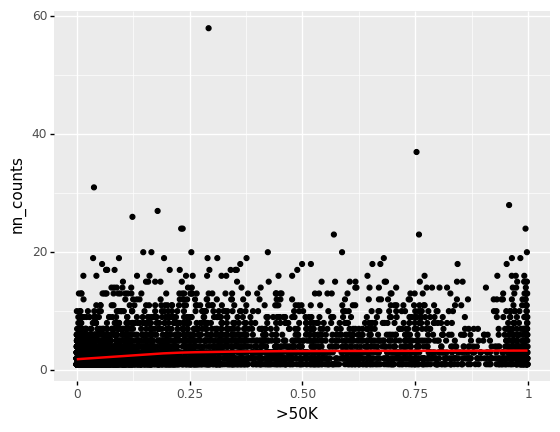

<ggplot: (8787774898815)>

In [60]:
p9.ggplot(phat_pred_val, p9.aes(x = ' >50K', y='nn_counts')) + p9.geom_point()\
+ p9.stat_smooth(method='lowess', color='red')

/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_ydensity : Removed 2109 rows containing non-finite values.


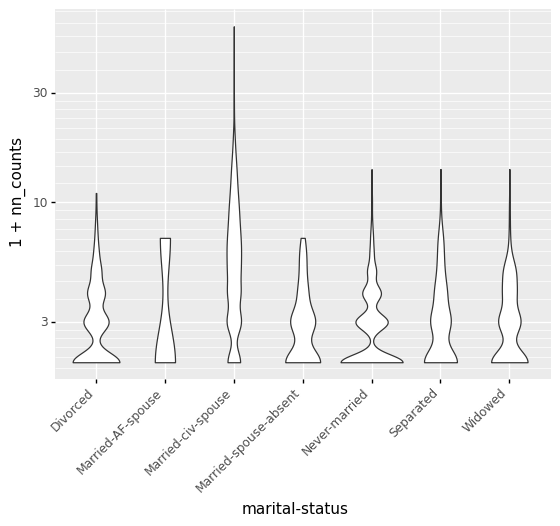

<ggplot: (8787748162250)>

In [61]:
p9.ggplot(val_cs, p9.aes(x='marital-status', y='1 + nn_counts')) + p9.geom_violin()\
+ p9.scale_y_log10() + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))

In [62]:
pd.DataFrame(
    {
        'train': train_cs.value_counts('marital-status', normalize=True),
        'test': test_cs.value_counts('marital-status', normalize=True)
    }
)

,train,test
marital-status,,
Divorced,0.161830,0.093568
Married-AF-spouse,0.000664,0.000855
Married-civ-spouse,0.339851,0.647009
Married-spouse-absent,0.015926,0.006951
Never-married,0.407804,0.210661
Separated,0.037604,0.020585
Widowed,0.036321,0.020371


In [63]:
yhat_test = pred_cs.predict(test_cs)
yhat_val = pred_cs.predict(val_cs)

In [64]:
yhat_val.value_counts(normalize=True)

 <=50K    0.844459
 >50K     0.155541
Name: class, dtype: float64

In [65]:
yhat_test.value_counts(normalize=True)

 <=50K    0.742341
 >50K     0.257659
Name: class, dtype: float64

In [66]:
label_ct = pd.DataFrame(
{
    'val': yhat_val.value_counts(),
    'test': yhat_test.value_counts()
}
)

In [67]:
from scipy import stats

In [68]:
stats.fisher_exact(label_ct)

(1.8844153483323058, 6.758201517917882e-75)

In [69]:
val_cs['yhat'] = yhat_val

In [70]:
pjoint_dist = val_cs.value_counts(['class','yhat'], normalize = True)

In [71]:
pcond_dist = pjoint_dist / pjoint_dist.groupby(level=0).sum()

In [72]:
q_yhat = yhat_test.value_counts(normalize=True)

In [73]:
q_yhat

 <=50K    0.742341
 >50K     0.257659
Name: class, dtype: float64

In [74]:
P_jnt = pd.pivot(pcond_dist.reset_index(), index='class', columns='yhat').T.values

In [75]:
q_yhat

 <=50K    0.742341
 >50K     0.257659
Name: class, dtype: float64

In [76]:
np.linalg.solve(P_jnt, q_yhat)

array([0.62539587, 0.37460413])

In [77]:
P_jnt

array([[0.95896078, 0.38069705],
       [0.04103922, 0.61930295]])

In [78]:
pjoint_dist

class   yhat  
 <=50K   <=50K    0.769078
 >50K    >50K     0.122628
         <=50K    0.075382
 <=50K   >50K     0.032913
dtype: float64

In [79]:
test_cs.value_counts('class',normalize=True)

class
 <=50K    0.688232
 >50K     0.311768
dtype: float64